In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
import random
import string
from sklearn.model_selection import train_test_split

def collect_font_files(fonts_dir):
    '''Сбор файлов шрифтов'''
    font_files = []
    for root, dirs, files in os.walk(fonts_dir):
        for file in files:
            if file.endswith(".ttf") or file.endswith(".otf"):
                font_files.append(os.path.join(root, file))
    return font_files

def generate_images(fonts, output_dir="dataset", num_images=100, img_size=(2048, 256)):
    '''Генерация датасета и разделение строк на символы'''
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    font_size = 200
    char_images = []
    char_labels = []
    for font_file in fonts:
        font_name = os.path.splitext(os.path.basename(font_file))[0]
        font_output_dir = os.path.join(output_dir, font_name)
        if not os.path.exists(font_output_dir):
            os.makedirs(font_output_dir)

        for i in range(num_images):
            text = random_string(random.randint(1, 15))
            image = Image.new("L", img_size, color=255)
            draw = ImageDraw.Draw(image)
            font = ImageFont.truetype(font_file, size=font_size)
            draw.text((10, 10), text, font=font, fill=0)
            image_path = os.path.join(font_output_dir, f"{font_name}_{i}.png")
            image.save(image_path)
            image_array = np.array(image)
            
            contours = find_contours(image)
            symbols = extract_symbols(image, contours)
            for symbol in symbols:
                char_images.append(symbol)
                char_labels.append(font_name)

    return np.array(char_images), np.array(char_labels)

def random_string(length):
    '''
    Вспомогательная функция: 
    Генерация случайной строки латинского алфавита и цифр
    '''
    letters = string.ascii_letters + string.digits
    return ''.join(random.choice(letters) for i in range(length))

def find_contours(char_image):
    '''
    Вспомогательная функция: 
    Поиск контуров букв
    '''
    im_array = np.array(char_image)
    if len(im_array.shape) == 3:
        im_gray = cv2.cvtColor(im_array, cv2.COLOR_RGB2GRAY)
    else:
        im_gray = im_array

    im_th = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    ctrs, _ = cv2.findContours(im_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cv2.boundingRect(ctr) for ctr in ctrs]
    return contours

def extract_symbols(char_image, contours):
    '''
    Вспомогательная функция: 
    Выделение отдельных символов из строки
    '''
    symbols = []
    for (x, y, w, h) in contours:
        symbol = char_image.crop((x, y, x + w, y + h))
        symbol = symbol.resize((28, 28))
        symbols.append(np.array(symbol))
    return symbols


# Путь к директории с шрифтами
fonts_dir = "fonts"

# Сбор файлов шрифтов
fonts = collect_font_files(fonts_dir)

# Генерация изображений и меток
images, labels = generate_images(fonts)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Сохранение обучающую и тестовую выборки
np.savez("fonts_dataset.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input


def build_model(num_classes):
    '''
    Создание и компиляция модели сверточной нейронной сети для классификации изображений.

    Параметры:
        num_classes (int): Количество классов в задаче классификации.

    Возвращает:
        Sequential: Модель Keras, готовая к обучению.

    Описание модели:
        1. Input layer: Принимает изображения размером 28x28 пикселей с одним каналом (черно-белые).
        2. Conv2D layer: Сверточный слой с 32 фильтрами размером 3x3 и функцией активации ReLU.
        3. MaxPooling2D layer: Слой максимального пулинга с размером пула 2x2.
        4. Dropout layer: Слой исключения с коэффициентом 0.5 для предотвращения переобучения.
        5. Flatten layer: Преобразует многомерные карты признаков в одномерный вектор.
        6. Dense layer: Полносвязный слой с 128 нейронами и функцией активации ReLU.
        7. Output Dense layer: Выходной полносвязный слой с количеством нейронов, равным количеству классов, и функцией активации Softmax для многоклассовой классификации.

    Компиляция модели:
        - Оптимизатор: Adam.
        - Функция потерь: categorical_crossentropy.
        - Метрика: accuracy.
    '''
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Определение количества классов (шрифтов)
num_classes = len(set(labels))
model = build_model(num_classes)

# Компиляция модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Печать сводки модели
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 694,607 (2.65 MB)

 Trainable params: 694,607 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
77/77 - 1s - 19ms/step - accuracy: 0.6068 - loss: 1.3106 - val_accuracy: 0.8461 - val_loss: 0.5774
Epoch 2/15
77/77 - 1s - 10ms/step - accuracy: 0.8818 - loss: 0.4335 - val_accuracy: 0.9322 - val_loss: 0.2702
Epoch 3/15
77/77 - 1s - 11ms/step - accuracy: 0.9347 - loss: 0.2468 - val_accuracy: 0.9720 - val_loss: 0.1568
Epoch 4/15
77/77 - 1s - 12ms/step - accuracy: 0.9561 - loss: 0.1733 - val_accuracy: 0.9773 - val_loss: 0.1082
Epoch 5/15
77/77 - 1s - 11ms/step - accuracy: 0.9668 - loss: 0.1281 - val_accuracy: 0.9801 - val_loss: 0.0792
Epoch 6/15
77/77 - 1s - 11ms/step - accuracy: 0.9739 - loss: 0.1007 - val_accuracy: 0.9874 - val_loss: 0.0602
Epoch 7/15
77/77 - 1s - 11ms/step - accuracy: 0.9756 - loss: 0.0865 - val_accuracy: 0.9882 - val_loss: 0.0509
Epoch 8/15
77/77 - 1s - 11ms/step - accuracy: 0.9782 - loss: 0.0731 - val_accuracy: 0.9911 - val_loss: 0.0407
Epoch 9/15
77/77 - 1s - 11ms/step - accuracy: 0.9810 - loss: 0.0646 - val_accuracy: 0.9903 - val_loss: 0.0402
Epoch 10/1

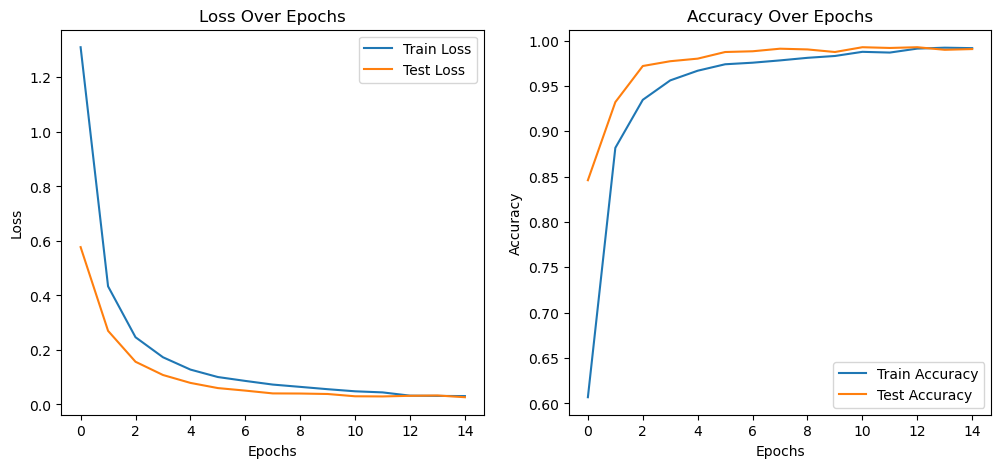

Test loss: 0.028, Test accuracy: 0.991
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       185
           1       0.99      0.97      0.98       164
           2       0.97      0.99      0.98       176
           3       1.00      0.96      0.98       160
           4       0.99      1.00      1.00       148
           5       0.97      1.00      0.99       172
           6       0.99      1.00      1.00       153
           7       1.00      1.00      1.00       159
           8       1.00      1.00      1.00       168
           9       1.00      0.99      1.00       148
          10       0.99      1.00      1.00       178
          11       0.98      0.97      0.98       151
          12       1.00      0.99      1.00       175
          13       0.99      1.00      1.00       149
          14       0.98      0.98      0.98       176

    accuracy                     

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import classification_report, confusion_matrix


def train_model(model, X_train, y_train, X_test, y_test, epochs=15, batch_size=128):
    '''Обучение модели и визуалиция результатов'''
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), verbose=2)
    
    # Логгирование результатов в DataFrame
    history_df = pd.DataFrame(history.history)
    history_df.to_csv('training_log.csv', index=False)

    # Отрисовка графиков
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Оценка модели
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")
    
    # Предсказание классов для тестовых данных
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Вывод отчета о классификации и матрицы ошибок
    print("Classification Report:")
    print(classification_report(y_test_encoded, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test_encoded, y_pred))
    
    model.save("font_recognition_model.keras")

    return model


# Подготовка данных
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.ravel())
y_test_encoded = label_encoder.transform(y_test.ravel())
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)
    
# Нормализация данных
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0
X_train_normalized = np.expand_dims(X_train_normalized, axis=-1)
X_test_normalized = np.expand_dims(X_test_normalized, axis=-1)

# Обучение модели
model = train_model(model, X_train_normalized, y_train_onehot, X_test_normalized, y_test_onehot)